INFO: Recompiling stale cache file /home/tom/.julia/lib/v0.4/Plots.ji for module Plots.


[Plots.jl] Initializing backend: gadfly
(xmeta,ymeta) = (nothing,nothing)
(xmeta,ymeta) = (nothing,nothing)
(xmeta,ymeta) = (nothing,nothing)
(xmeta,ymeta) = (nothing,nothing)

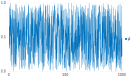

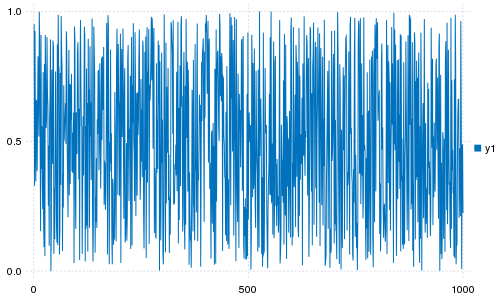

In [1]:
using Plots; gadfly()
default(size=(500,300))
p1 = plot(rand(20))
p2 = plot(rand(10))
p3 = scatter(rand(100))
p4 = plot(rand(1000))

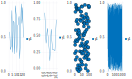

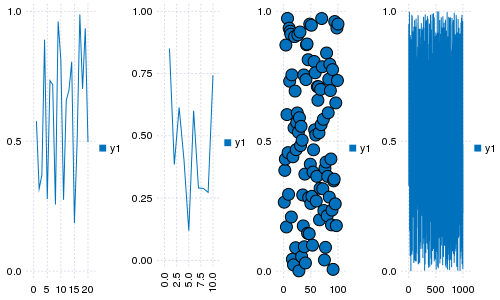

In [2]:
subplot(p1,p2,p3,p4, nr=1, leg=false)

In [ ]:
methods(subplot)

In [ ]:
typeof(p2)